<a href="https://colab.research.google.com/github/supramm/TATASecureVision/blob/main/TATASecureVision_HarnessTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect Runtime(T4)
#Mount Drive

In [8]:
#import Dataset
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qCa5x1tRk4MP4mUvrYyT")
project = rf.workspace("supram").project("harness_merge-vfllm")
version = project.version(2)
dataset = version.download("yolov11")

print()
print("Dataset:",dataset.location)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Harness_Merge-2 in yolov11:: 100%|██████████| 378/378 [00:00<00:00, 7759.21it/s]


Dataset: /content/Harness_Merge-2


In [6]:
#install YOLO
!pip install -q ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.8/112.6 GB disk)


In [35]:
import albumentations as A
import cv2
import torch
import numpy as np
from ultralytics.data.dataset import YOLODataset

class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)
        self.train_mode = "train" in self.prefix

        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()

        # Albumentations pipeline (strong augmentation for "No_Harness" class)
        self.no_harness_aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Rotate(limit=20, p=0.5),
            A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), p=0.5),
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    def count_instances(self):
        self.counts = [0 for _ in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1
        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            if cls.size == 0:
                weights.append(1)
                continue
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        total_weight = sum(self.weights)
        return [w / total_weight for w in self.weights]

    def __getitem__(self, index):
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            image, label = self.get_image_and_label(index)

            cls_ids = label['cls'].reshape(-1).astype(int)

            # Ensure bboxes are in YOLO format
            if 'bboxes' not in label:
                label['bboxes'] = self.xyxy2yolo(label['bboxes'], image.shape)
            bboxes = label['bboxes']

            # Apply strong augmentation only if "No_Harness" class is present
            if 'No_Harness' in self.data['names']:
                no_harness_id = self.data['names'].index('No_Harness')
                if no_harness_id in cls_ids:
                    bboxes_yolo = [list(bbox) for bbox in bboxes]
                    transformed = self.no_harness_aug(image=image, bboxes=bboxes_yolo, class_labels=cls_ids.tolist())
                    image = transformed['image']
                    label['bboxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                    label['cls'] = torch.tensor(transformed['class_labels'], dtype=torch.long)

            return self.transforms((image, label))
#src: https://y-t-g.github.io/tutorials/yolo-class-balancing/

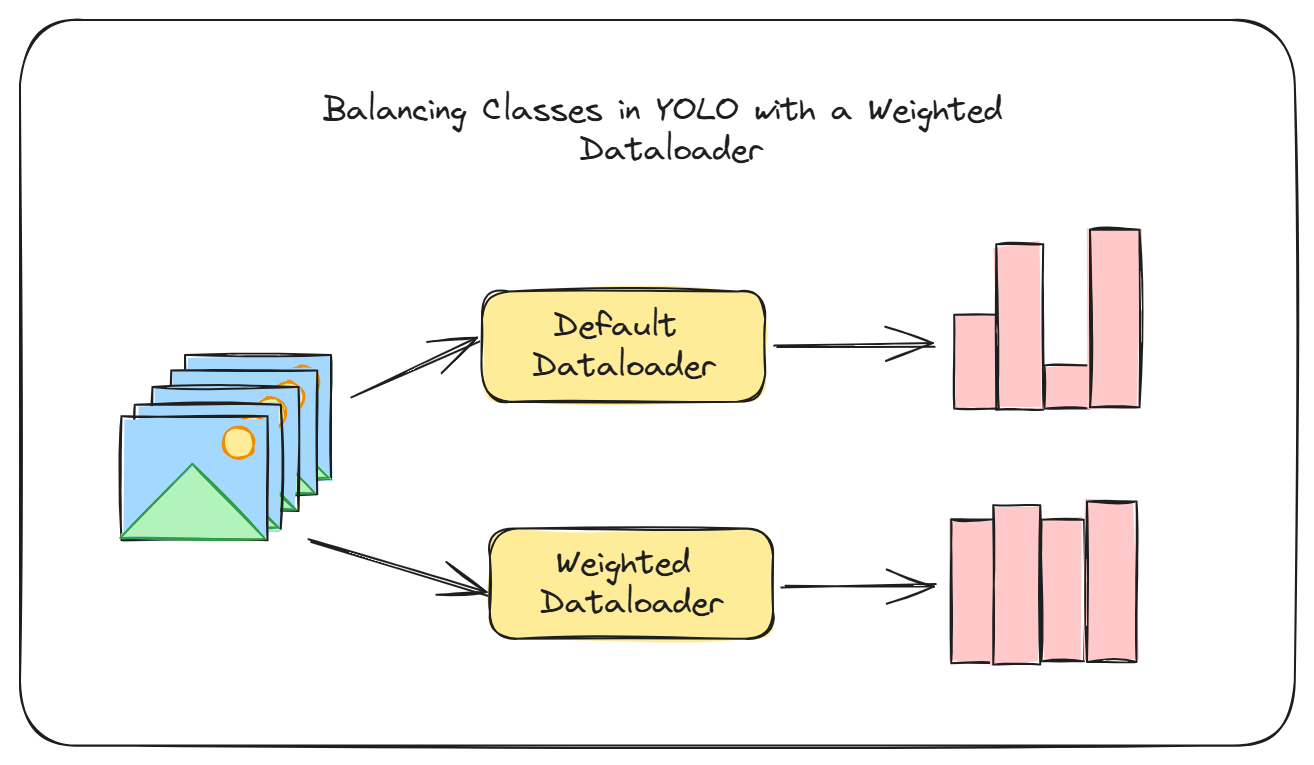

In [36]:
import ultralytics.data.build as build

build.YOLODataset = YOLOWeightedDataset

In [37]:
!yolo detect train model=yolo11s.pt data=/content/Harness_Merge-2/data.yaml imgsz=640 epochs=100

Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Harness_Merge-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

In [39]:
!yolo detect predict model=/content/runs/detect/train8/weights/best.pt source=/content/Harness_Merge-2/valid save=True

Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 983, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 555, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/predictor.py", line 247, in predict_cli
    for _ in gen:  # sourcery skip: remove-empty-nested-block, noqa
  File "/usr/local/lib/python3.11/dist-packages/t